In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Классификация жанров музыки

Допустим у нас есть сервис для прослушивания музыки, который имеет множество композиций, доступных для прослушивания. Мы хотим предоставить пользователю удобный поиск по жанрам и улучшить систему рекомендаций. Так как информация о композиции, предоставленная исполнителем, может быть недостаточна, нужно определять жанр автоматически, основываясь на некоторых характеристиках этой композиции.

## Загрузка и описание данных

In [2]:
# url = "https://raw.githubusercontent.com/oleg-w570/machine-learning/main/music_genre_classification.csv"
# data_raw = pd.read_csv(url)
path = 'music_genre_classification.csv'
data_raw = pd.read_csv(path)


In [3]:
data_raw.head()

Artist Name                             Track Name  Popularity  \
0             Bruno Mars  That's What I Like (feat. Gucci Mane)        60.0   
1                 Boston                           Hitch a Ride        54.0   
2          The Raincoats                     No Side to Fall In        35.0   
3                   Deno             Lingo (feat. J.I & Chunkz)        66.0   
4  Red Hot Chili Peppers      Nobody Weird Like Me - Remastered        53.0   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.854   0.564   1.0    -4.964     1       0.0485      0.017100   
1         0.382   0.814   3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614   6.0    -8.334     1       0.0525      0.486000   
3         0.853   0.597  10.0    -6.528     0       0.0555      0.021200   
4         0.167   0.975   2.0    -4.279     1       0.2160      0.000169   

   instrumentalness  liveness  valence    tempo  duration_in min/ms  \
0               NaN    0.0849   0.8990  134.071            234596.0   
1          0.004010    0.1010   0.5690  116.454            251733.0   
2          0.000196    0.3940   0.7870  147.681            109667.0   
3               NaN    0.1220   0.5690  107.033            173968.0   
4          0.016100    0.1720   0.0918  199.060            229960.0   

   time_signature  Class  
0               4      5  
1               4     10  
2               4      6  
3               4      5  
4               4     10

Таблица содержит данные о 17996 композициях. Для каждой композиции представлено 17 признаков:
* `Artist name` -- имя исполнителя (текстовый признак)
* `Track name` -- название песни (текстовый признак)
* `Popularity` -- популярность песни: чем больше значение, тем популярнее
* `danceability` -- 'танцевальность' песни: чем больше значение, тем легче под неё танцевать (в процентах)
* `energy` -- энергичность песни: чем больше значение, тем песня более энергичная (в процентах)
* `key` -- тональность песни: категориальный признак, 11 значений
* `loudness` -- 'громкость' песни: чем больше значение, тем громче песня
* `mode` -- стиль песни: категориальный признак, 0 -- минор, 1 -- мажор
* `speechiness` -- чем выше значение, тем больше слов в песне (в процентах)
* `acousticness` -- количество акустического звука в песне (в процентах)
* `instrumentalness` -- количество инструментального содержания в песне (в процентах)
* `liveness` -- наличие элементов живого исполнения (в процентах)
* `vilence` -- позитивность песни (в процентах)
* `tempo` -- темп: скорость исполнения музыки
* `duration` -- длительность в милисекундах
* `time signature` -- размер такта: категориальный признак, 4 значения
* `Class` -- жанр песни: 11 значений

## Текстовые признаки

Столбцы с именами исполнителей и названиями песен, как мне кажется, можно убрать из рассмотрения, потому что они не принесут пользы для классификации.

In [4]:
data = data_raw.select_dtypes(exclude='object')

## Странность в длительностях композиций

Датасет представляет значения длительности песен в двух единицах измерения -- одни значения в минутах, другие в миллисекундах. 
Исправим это, приведя все значения в миллисекунды.
Для этого вполне разумно считать все малые значения, например, меньше сотни -- значениями в минутах. 
Одна минута -- это 60 секунд, одна секунда -- это 1000 миллисекунд.

In [5]:
data.loc[data['duration_in min/ms'] < 100, 'duration_in min/ms'] *= 60000

Для красоты сократим название этого столбца:

In [6]:
data.rename(columns = {'duration_in min/ms': 'duration'}, inplace=True)

## Названия жанров

Столбец Class содержит жанры композиций, но представляет их как числа:

In [7]:
data['Class'].unique()

array([ 5, 10,  6,  2,  4,  8,  9,  3,  7,  1,  0], dtype=int64)

Для красоты дадим им настоящие названия:

In [8]:
class_name = ["Acoustic/Folk", "Alt", "Blues", "Bollywood", "Country", "HipHop", "Indie", "Instrumental", "Metal", "Pop", "Rock"]
class_mapping = { i : class_name[i] for i in range(11)}
data['Class'] = data['Class'].map(class_mapping)
data['Class'].unique()

array(['HipHop', 'Rock', 'Indie', 'Blues', 'Country', 'Metal', 'Pop',
       'Bollywood', 'Instrumental', 'Alt', 'Acoustic/Folk'], dtype=object)

И укажем, что это категориальный тип:

In [9]:
data['Class'] = data['Class'].astype('category')

## Обработка пропущенных значений

Посмотрим, сколько имеем пропущенных значений в каждом столбце:

In [10]:
data.isna().sum()

Popularity           428
danceability           0
energy                 0
key                 2014
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness    4377
liveness               0
valence                0
tempo                  0
duration               0
time_signature         0
Class                  0
dtype: int64

Строк с пропущенными значениями не мало, поэтому удалять их будет не разумно.

Заполним медианой пропущенные значения в столбцах с числовыми признаками:

In [11]:
from sklearn.impute import SimpleImputer
col_with_missing_value = ['Popularity', 'key' ,'instrumentalness']
imp_num = SimpleImputer(strategy='median')
imp_num.fit(data[col_with_missing_value])
data[col_with_missing_value] = imp_num.transform(data[col_with_missing_value])

Убедимся, что пропущенных значений более нет:

In [12]:
data.isna().sum()

Popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration            0
time_signature      0
Class               0
dtype: int64

## Обработка категориальных признаков

Категориальные признаки у нас это: тональность (key), стиль (mode), размер такта (time signature).

In [13]:
categorical_columns = ['key', 'mode', 'time_signature']

Все они представлены числами:

In [14]:
for col in categorical_columns:
    print(col, data[col].unique())

key [ 1.  3.  6. 10.  2.  5.  7.  9. 11.  8.  4.]
mode [1 0]
time_signature [4 3 1 5]


Бинарный признак mode уже обработан, заменён на числовой. Небинарные признаки key и time signature также закодированы числовыми значениями. Применять метод бинаризации (векторизации) кажется не совсем правильным, так как появиться много новых признаков, что может привести к переобучению. Поэтому оставим текущий метод, только приведём к отрезку, начинающегося с нуля.

Для этого воспользуемся ordinal encoder из sklearn:

In [15]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(data[categorical_columns])

OrdinalEncoder()

Преобразуем:

In [16]:
data[categorical_columns] = enc.transform(data[categorical_columns])

Укажем, что это категориальный тип:

In [17]:
data[categorical_columns] = data[categorical_columns].astype('category')

## Визуализация данных, основные характеристики

Для изображения диаграммы рассеивания будем использовать только 1000 случайных точек:

In [18]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)

Построим все возможные диаграммы рассеивания для каждой пары переменных:

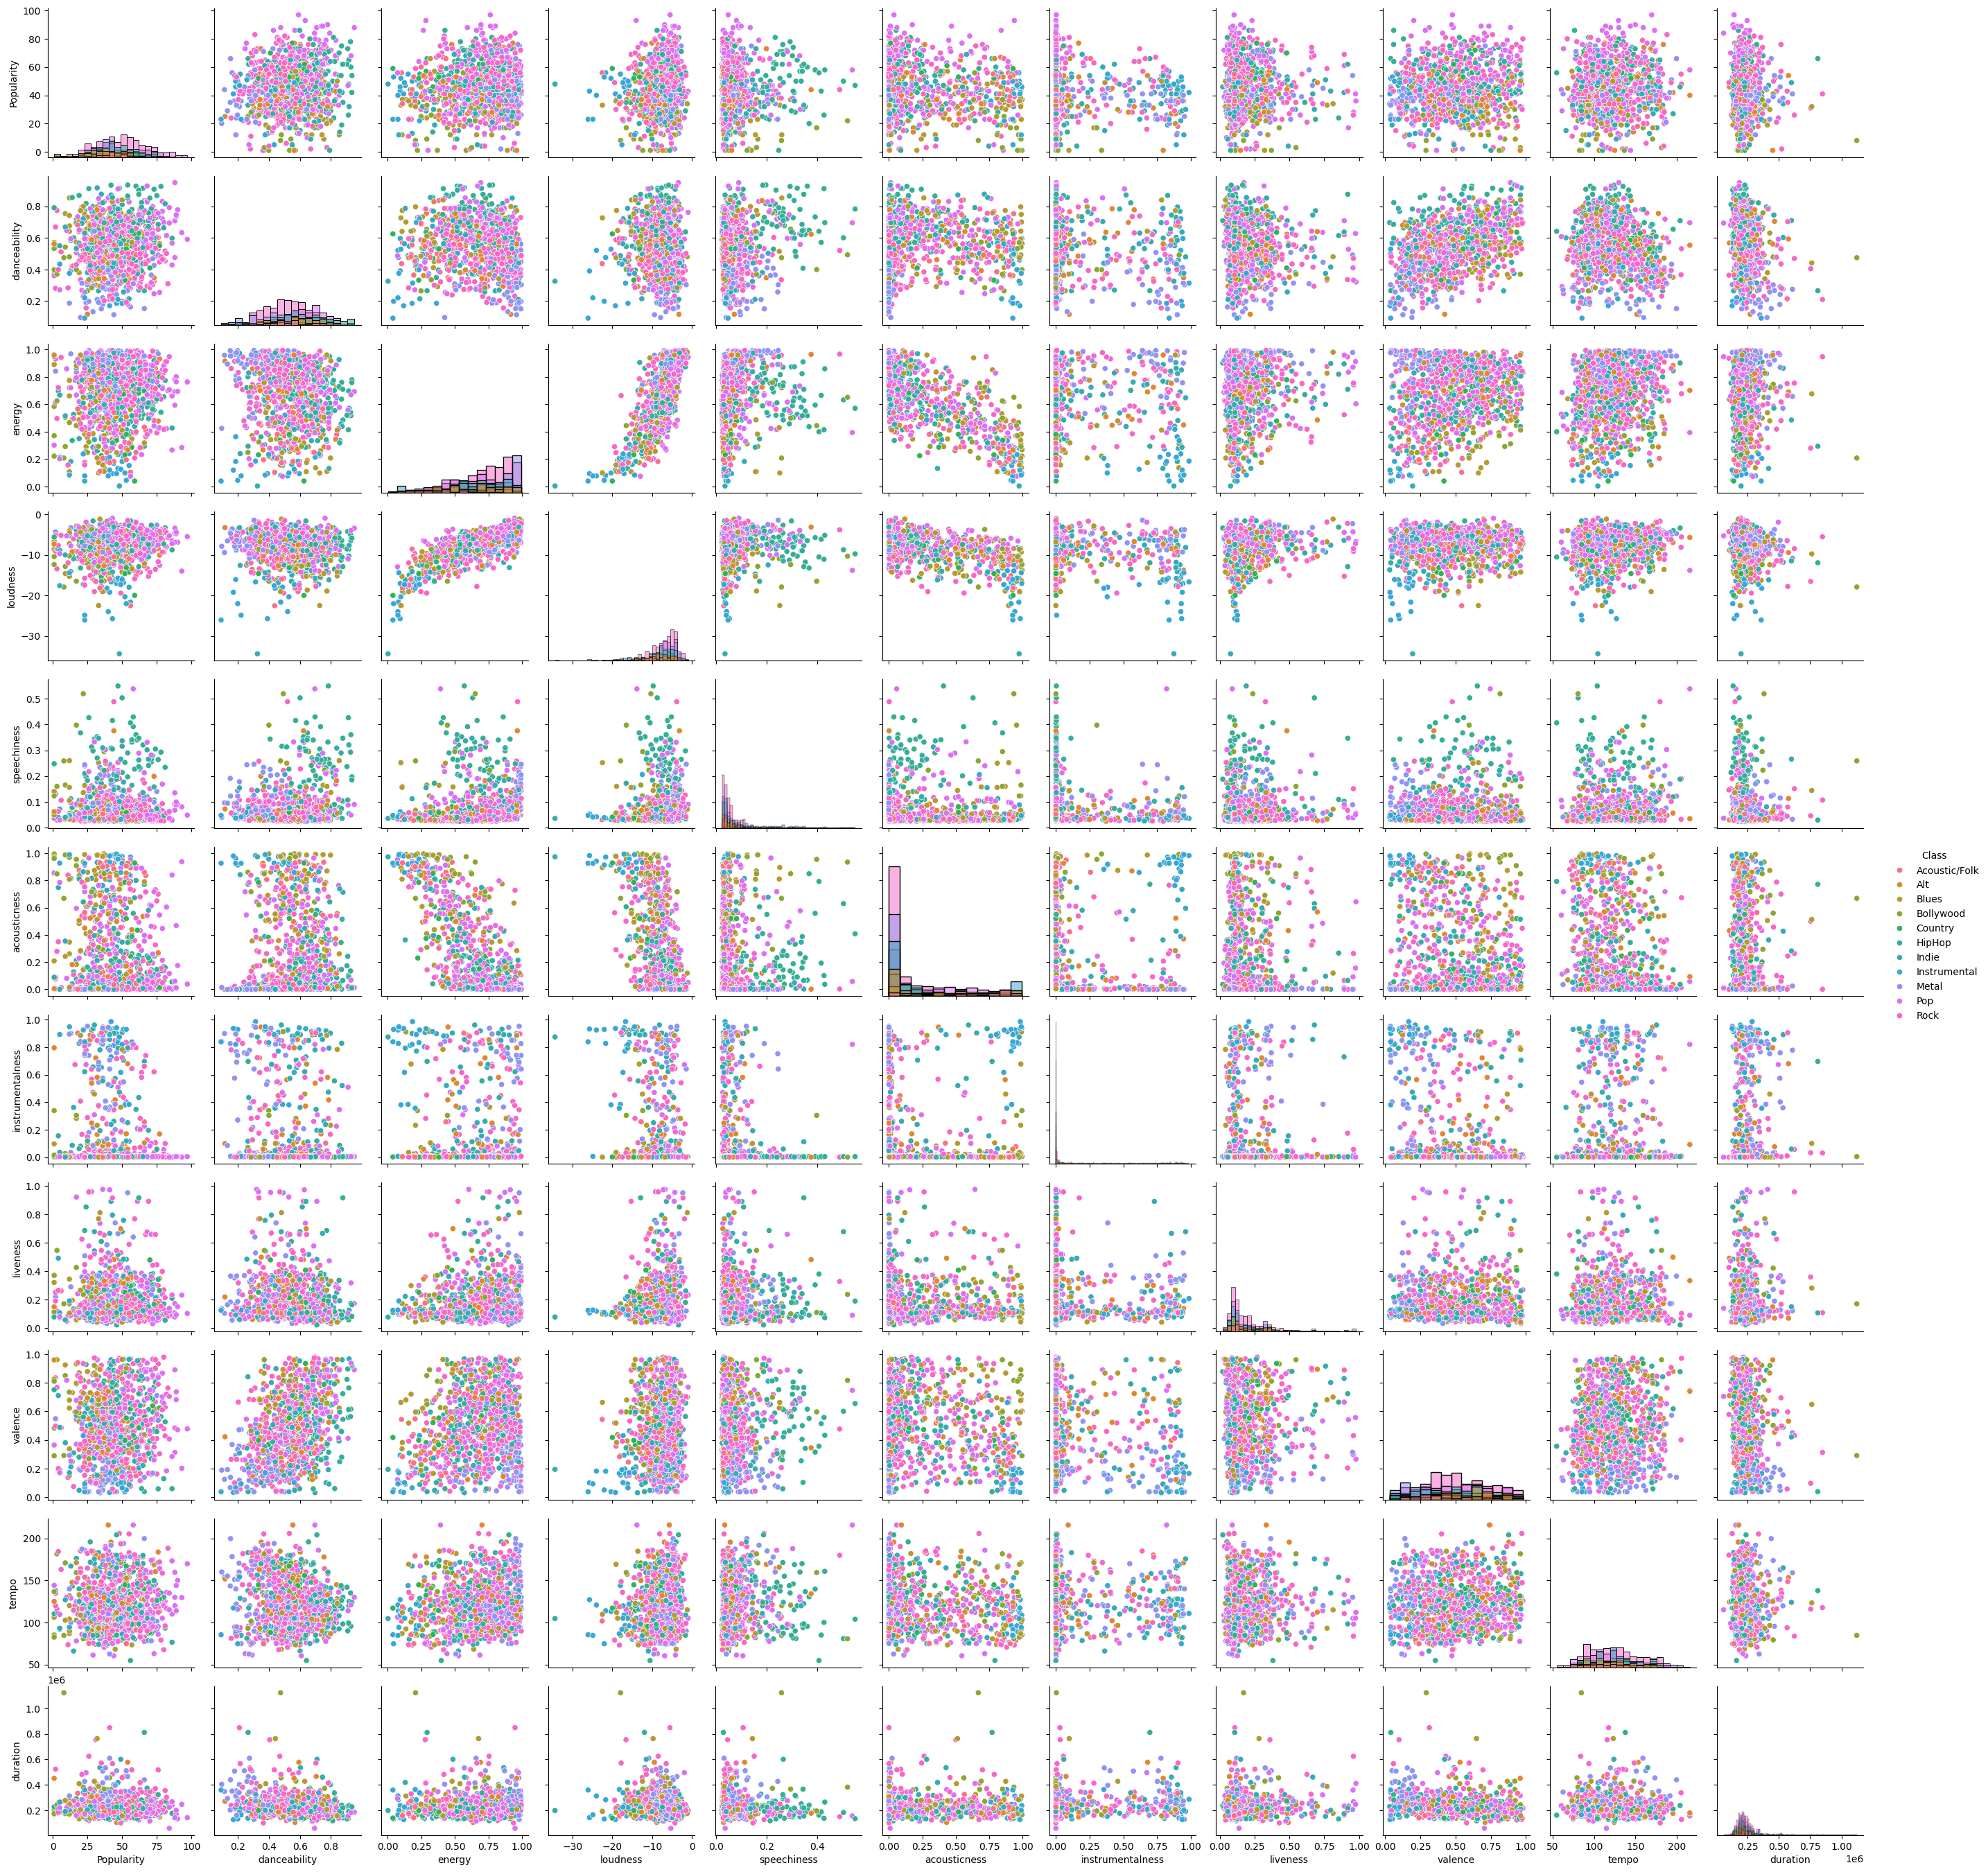

In [19]:
sns.pairplot(data.iloc[random_subset], hue='Class', diag_kind='hist')
pass

Особой корреляции между признаками не наблюдается, разве что, между loudness и energy.

Построим гистограммы признаков:

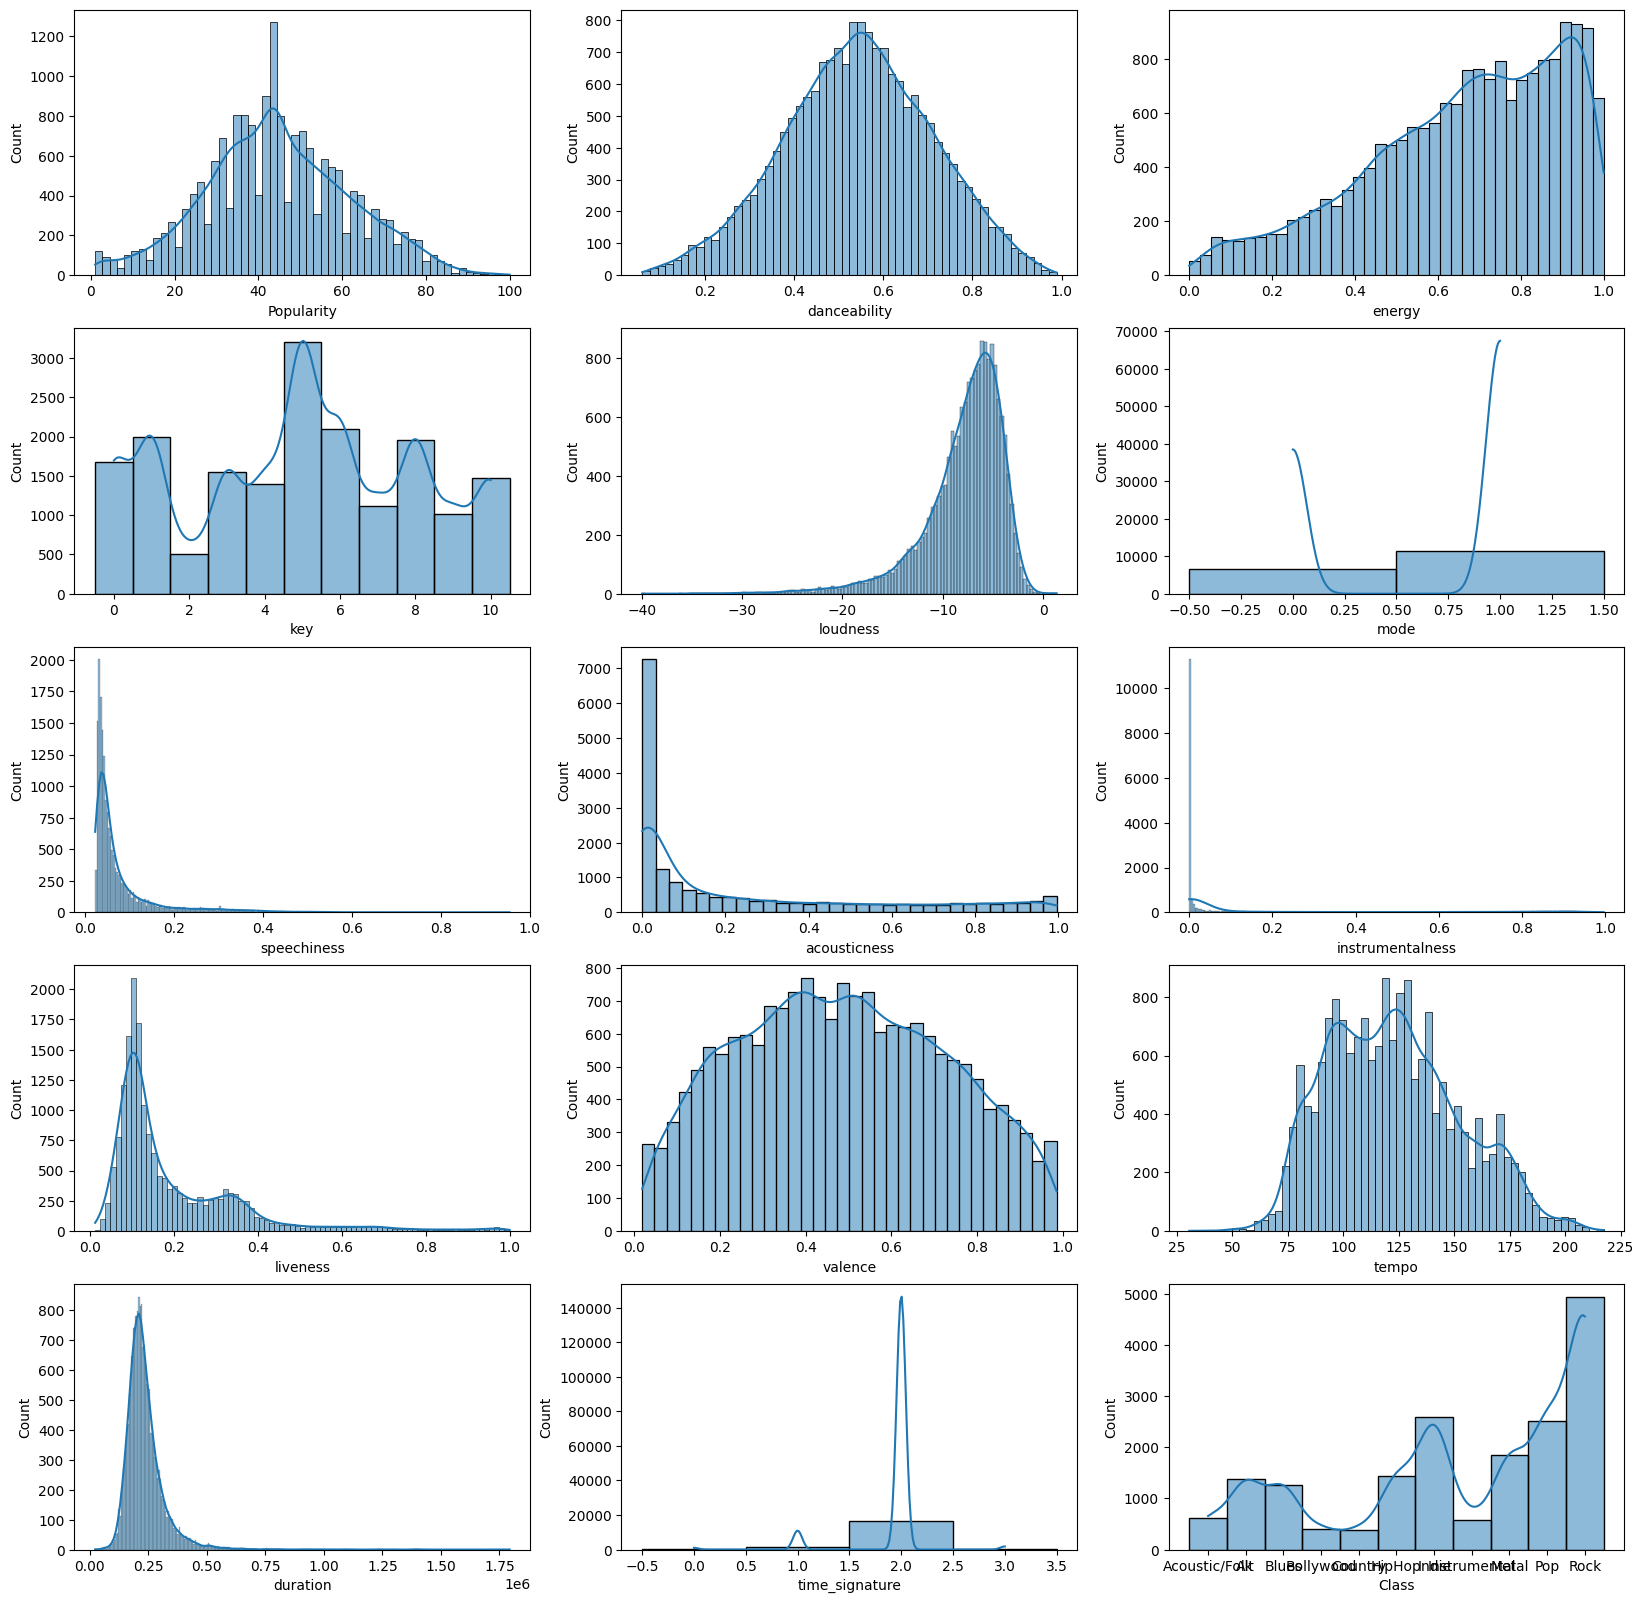

In [20]:
plt.figure(figsize=(20, 20))
for i, column in enumerate(data.columns):
    plt.subplot(5, 3, i+1)
    sns.histplot(data[column], kde=True)

Вычислим характеристики признаков:

In [21]:
data.describe().transpose()

count           mean           std           min  \
Popularity        17996.0      44.499944     17.218613      1.000000   
danceability      17996.0       0.543433      0.166268      0.059600   
energy            17996.0       0.662777      0.235373      0.000020   
loudness          17996.0      -7.910660      4.049151    -39.952000   
speechiness       17996.0       0.079707      0.083576      0.022500   
acousticness      17996.0       0.247082      0.310632      0.000000   
instrumentalness  17996.0       0.135326      0.274791      0.000001   
liveness          17996.0       0.196170      0.159212      0.011900   
valence           17996.0       0.486208      0.240195      0.018300   
tempo             17996.0     122.623294     29.571527     30.557000   
duration          17996.0  235823.283452  85675.030192  23320.000000   

                            25%           50%           75%          max  
Popularity            33.000000      44.00000      56.00000      100.000  
danceability           0.432000       0.54500       0.65900        0.989  
energy                 0.509000       0.70000       0.86000        1.000  
loudness              -9.538000      -7.01600      -5.18900        1.355  
speechiness            0.034800       0.04740       0.08300        0.955  
acousticness           0.004300       0.08140       0.43400        0.996  
instrumentalness       0.000294       0.00391       0.05660        0.996  
liveness               0.097500       0.12900       0.25800        1.000  
valence                0.297000       0.48100       0.67200        0.986  
tempo                 99.620750     120.06550     141.96925      217.416  
duration          187649.749995  220000.00000  263082.25000  1793160.000

In [22]:
data.describe(include='category').transpose()

count unique   top     freq
key             17996.0   11.0   5.0   3204.0
mode            17996.0    2.0   1.0  11459.0
time_signature  17996.0    4.0   2.0  16451.0
Class             17996     11  Rock     4949

Найдём матрицу корреляции:

In [23]:
corr_mat = data.corr(numeric_only=True)
corr_mat

Popularity  danceability    energy  loudness  speechiness  \
Popularity          1.000000      0.165469  0.050873  0.122428     0.031329   
danceability        0.165469      1.000000 -0.093838  0.059723     0.199042   
energy              0.050873     -0.093838  1.000000  0.767869     0.125427   
loudness            0.122428      0.059723  0.767869  1.000000     0.096027   
speechiness         0.031329      0.199042  0.125427  0.096027     1.000000   
acousticness       -0.123594      0.009055 -0.745963 -0.612824    -0.086648   
instrumentalness   -0.170386     -0.219255 -0.151817 -0.348796    -0.100555   
liveness           -0.071643     -0.109485  0.195634  0.112022     0.070406   
valence             0.054171      0.444548  0.222998  0.181086     0.053885   
tempo              -0.005924     -0.183527  0.210224  0.164272     0.048948   
duration           -0.105367     -0.232649 -0.012034 -0.112237    -0.113281   

                  acousticness  instrumentalness  liveness   valence  \
Popularity           -0.123594         -0.170386 -0.071643  0.054171   
danceability          0.009055         -0.219255 -0.109485  0.444548   
energy               -0.745963         -0.151817  0.195634  0.222998   
loudness             -0.612824         -0.348796  0.112022  0.181086   
speechiness          -0.086648         -0.100555  0.070406  0.053885   
acousticness          1.000000          0.146809 -0.111393 -0.122547   
instrumentalness      0.146809          1.000000 -0.041411 -0.223621   
liveness             -0.111393         -0.041411  1.000000  0.021076   
valence              -0.122547         -0.223621  0.021076  1.000000   
tempo                -0.168318         -0.028771  0.033515  0.051128   
duration             -0.008050          0.154668  0.059197 -0.183862   

                     tempo  duration  
Popularity       -0.005924 -0.105367  
danceability     -0.183527 -0.232649  
energy            0.210224 -0.012034  
loudness          0.164272 -0.112237  
speechiness       0.048948 -0.113281  
acousticness     -0.168318 -0.008050  
instrumentalness -0.028771  0.154668  
liveness          0.033515  0.059197  
valence           0.051128 -0.183862  
tempo             1.000000 -0.030168  
duration         -0.030168  1.000000

Изобразим её графически:

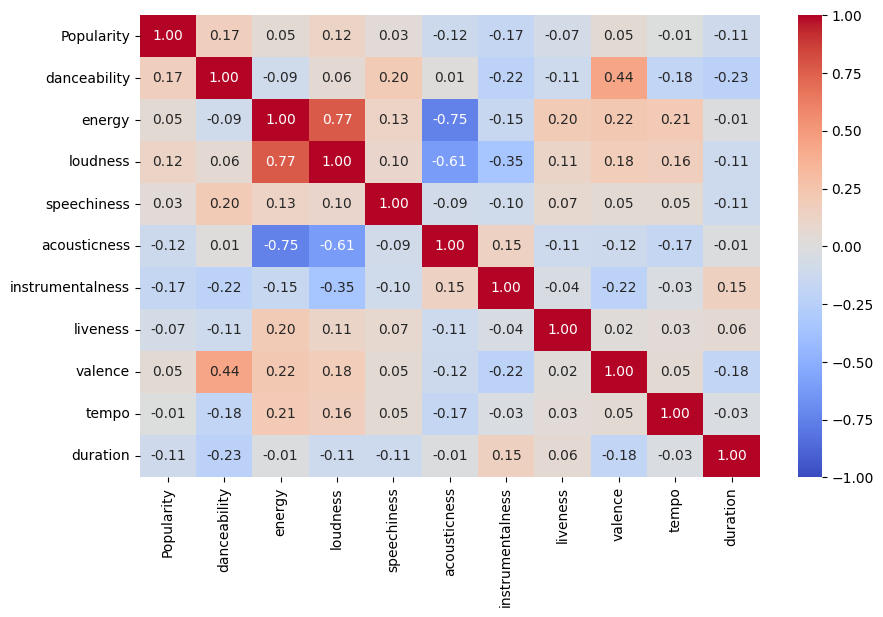

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='0.2f')
pass

## Масштабирование количественных признаков

Выполним стандартизацию всех признаков:

In [25]:
from sklearn.preprocessing import StandardScaler
numerical_columns = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', "acousticness", 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
data_numerical = data[numerical_columns]
scaler = StandardScaler()
scaler.fit(data_numerical)
data_numerical = pd.DataFrame(scaler.transform(data_numerical), columns=data_numerical.columns, index=data_numerical.index)
data[numerical_columns] = data_numerical

In [26]:
data.describe().transpose()

count          mean       std       min       25%  \
Popularity        17996.0 -5.280901e-17  1.000028 -2.526403 -0.667897   
danceability      17996.0 -4.880145e-16  1.000028 -2.910032 -0.670219   
energy            17996.0  1.891253e-16  1.000028 -2.815845 -0.653349   
loudness          17996.0  2.037342e-16  1.000028 -7.913321 -0.401908   
speechiness       17996.0 -8.923242e-17  1.000028 -0.684509 -0.537334   
acousticness      17996.0 -4.659038e-17  1.000028 -0.795438 -0.781594   
instrumentalness  17996.0 -2.526936e-17  1.000028 -0.492479 -0.491413   
liveness          17996.0  8.725825e-17  1.000028 -1.157422 -0.619758   
valence           17996.0 -1.437195e-16  1.000028 -1.948088 -0.787750   
tempo             17996.0 -1.048283e-16  1.000028 -3.113429 -0.777883   
duration          17996.0 -2.136050e-16  1.000028 -2.480410 -0.562298   

                       50%       75%        max  
Popularity       -0.029036  0.667904   3.223349  
danceability      0.009423  0.695081   2.679878  
energy            0.158150  0.837940   1.432756  
loudness          0.220956  0.672174   2.288360  
speechiness      -0.386569  0.039402  10.473302  
acousticness     -0.533384  0.601752   2.411015  
instrumentalness -0.478253 -0.286502   3.132186  
liveness         -0.421902  0.388362   5.048954  
valence          -0.021685  0.773523   2.080830  
tempo            -0.086498  0.654227   3.205629  
duration         -0.184695  0.318176  18.177758

## Обучающая и тестовая выборка

In [27]:
x = data.drop('Class', axis=1)
y = data['Class']

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)


## Метод k ближайших соседей

In [29]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(x_train, y_train)

KNeighborsClassifier()

In [30]:
y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

In [31]:
err_train = np.mean(y_train != y_train_predict)
err_test = np.mean(y_test != y_test_predict)

In [32]:
err_train, err_test

(0.42898421871527004, 0.6325850188930874)

Подберём оптимальные параметры

In [33]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(x_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors

In [34]:
best_cv_err, best_n_neighbors

(0.5535285396590067, 45)